This tutorial shows interoperability tools between Sopa and the Xenium Explorer. We show how to go back and forth, between analysis and visualization.

Ensure that you have already run Sopa, either with the Snakemake pipeline, CLI, or API.

For **image alignment** with the Xenium Explorer, refer to [this tutorial](https://gustaveroussy.github.io/sopa/tutorials/align/).

In [1]:
import sopa

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


For this tutorial, we use some generated data that looks similar to the output of Sopa.

In [2]:
# if you have your own data, use `sdata = spatialdata.read_zarr("...")` instead
sdata = sopa.io.toy_dataset(as_output=True)

[INFO] (sopa.utils.data) Image of size ((4, 2048, 2048)) with 400 cells and 100 transcripts per cell
[INFO] (sopa.aggregation.transcripts) Aggregating transcripts over 400 cells


[########################################] | 100% Completed | 249.06 ms


[INFO] (sopa.aggregation.channels) Averaging channels intensity over 400 cells with expansion expand_radius_ratio=0


[########################################] | 100% Completed | 106.16 ms


/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:96: UserWarning: Key `cellpose_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [8]:
explorer_path = "tuto.explorer" # directory where we'll save the Xenium Explorer data

Now, we need to create the Xenium Explorer input files.

> **If you have already run Sopa** on your own data, you have likely already done the step below.

In [ ]:
sopa.io.explorer.write(explorer_path, sdata)

[INFO] (sopa.io.explorer.table) Writing table with 6 columns
[INFO] (sopa.io.explorer.table) Writing 2 cell categories: region, slide
[INFO] (sopa.io.explorer.shapes) Writing 400 cell polygons
[INFO] (sopa.io.explorer.points) Writing 40000 transcripts
[INFO] (sopa.io.explorer.points)    > Level 0: 40000 transcripts
[INFO] (sopa.io.explorer.points)    > Level 1: 10000 transcripts
[INFO] (sopa.io.explorer.images) Writing multiscale image with procedure=semi-lazy (load in memory when possible)
[INFO] (sopa.io.explorer.images)    (Loading image of shape (4, 2048, 2048)) in memory
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 2048, 2048)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 1024, 1024)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 512, 512)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 256, 256)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 128, 128)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 64, 64)
[INFO] (sopa.

## Update the cell categories/clusters

Here, we run some Leiden clustering with `scanpy`. Then, we will update the Xenium Explorer files to display the spot clusters.

More generally, you can add new cell categories, i.e. a column of `sdata.table.obs`, and the Xenium Explorer will show it after the instructions below.

> Note that we only display categorical columns. If a column from `sdata.table.obs` contains continuous numerical values (e.g., `3.13, 7.89, ...`), it will not be transformed into a categorical variable, and therefore not shown in the Xenium Explorer. In this case, we recommend using the [`spatiadata_plot`](https://spatialdata.scverse.org/projects/plot/en/latest/index.html) static plotting library or the [`napari_spatialdata`](https://github.com/scverse/napari-spatialdata) interactive plotting library.

In [5]:
import scanpy as sc

adata = sdata.tables["table"]

In [6]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/rl/nsddz37s55zbfg5h7b060rlc0000gn/T/ipykernel_65623/852979259.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.1)


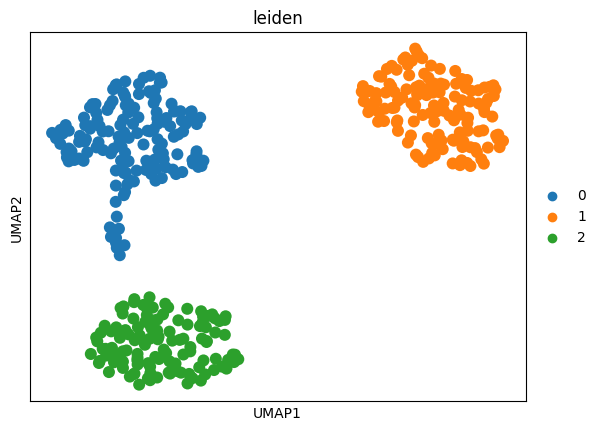

In [7]:
sc.pl.umap(adata, color="leiden")

Now, you can update the explorer with your new cluster assignment. You don't need to re-run the complete conversion; you can edit the `analysis.zarr.zip` file only, as below.

> Alternatively, you can use the `sopa` CLI instead of the API, as detailed [here](https://gustaveroussy.github.io/sopa/cli/#sopa-explorer-update-obs).

In [8]:
sopa.io.explorer.write_cell_categories(explorer_path, adata)

[INFO] (sopa.io.explorer.table) Writing 3 cell categories: region, slide, leiden


To visualize these clusters, re-open the `experiment.xenium` file and select the new `"leiden"` cell group (under the "Cells" panel and in the "Cell groups" dropdown). See the examples above to see how it looks on the Xenium Explorer.

<img src="../../../assets/explorer/leiden.png" alt="image" width="800" height="auto">

## Use the coordinates of a lasso selection in SpatialData

On the Xenium Explorer, you can use the Lasso or Rectangular selection tools to select some regions of interest. Then, you'll be able to analyze back this region of interest using `spatialdata`.


### Selecting cells from a selection
After making a selection, click on "Download Cell Stats as CSV", as below. It will create a file called `"Selection_1_cells_stats.csv"`.

<img src="../../../assets/explorer/lasso.png" alt="image" width="800" height="auto">

In [9]:
import pandas as pd

# write below the path to the file that you downloaded, e.g. "Selection_1_cells_stats.csv"
df_selection = pd.read_csv("Selection_1_cells_stats.csv", skiprows=2)

# we create a new column to annotate which cells were selected or not
adata.obs["lasso"] = "not-selected"
adata.obs.loc[df_selection["Cell ID"].values, "lasso"] = "selected"

Now, `sdata.table.obs["lasso"]` denotes which cells have been selected by the lasso tool (either "selected" or "not-selected").

We can then use `spatialdata_plot` to display the cells that were selected by the lasso tool. Make sure to install `spatialdata_plot >= 0.1.0`, e.g. via `pip install spatialdata_plot`. Now, we can render the shapes (i.e., the spots) and colour them based on the `"lasso"` column that was saved in `sdata.table.obs`:

In [10]:
import spatialdata_plot

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/spatialdata_plot/pl/basic.py:879: UserWarning: Converting copy of 'lasso' column to categorical dtype for categorical plotting. Consider converting before plotting.
  _render_shapes(
/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:782: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


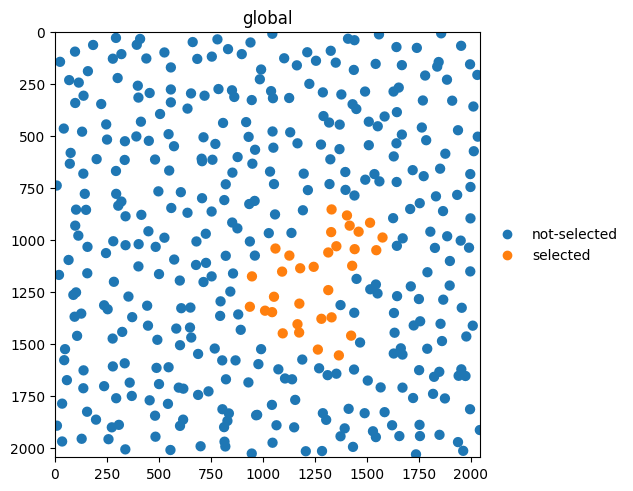

In [11]:
sdata.pl.render_shapes(color="lasso").pl.show("global")

### Cropping a SpatialData object from a selection

You can also export the whole selection as a polygon and use it to crop the `spatialdata` object. For that, click on "Download Selection Coordinates as CSV", as below. It will create a file called `"Selection_1_coordinates.csv"`.

<img src="../../../assets/explorer/lasso2.png" alt="image" width="800" height="auto">

Then, we read the polygon coordinates, and perform a polygon query on the `"global"` coordinate system (i.e., the pixel coordinate system).

> Note: if not using Xenium data, please provide the `pixel_size` argument in the `sopa.io.add_explorer_selection` function below (the `pixel_size` should be the one that has been used when running Sopa). If you used the snakemake pipeline, this argument can be found in the config. Without this, the polygon may not be in the right coordinate system.

In [12]:
import spatialdata_io

polygon = spatialdata_io.xenium_explorer_selection("Selection_1_coordinates.csv")

In [13]:
query_sdata = sdata.query.polygon(polygon, target_coordinate_system="global")
query_sdata

SpatialData object
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 523, 418), (3, 261, 209), (3, 131, 105)
│     └── 'image': DataArray[cyx] (4, 1044, 837)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 5) (2D points)
├── Shapes
│     └── 'cellpose_boundaries': GeoDataFrame shape: (47, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (47, 6)
with coordinate systems:
    ▸ 'global', with elements:
        he_image (Images), image (Images), transcripts (Points), cellpose_boundaries (Shapes)
    ▸ 'microns', with elements:
        transcripts (Points)

Using `spatialdata_plot`, we see that we indeed selected the cells we desired.

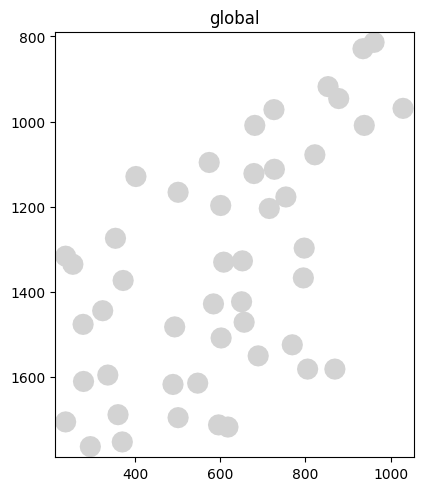

In [14]:
query_sdata.pl.render_shapes().pl.show("global")

## Segmentation overlay

Sometimes, you may need to select specific cells and update the segmentation accordingly. This can be specifically inetresting when you have multinucleated giant cells (MGC), which are difficult to segment. In that case, you can perform multiple lasso selections in the Xenium Explorer, and then download them all into one single file, as below.

<img src="../../../assets/explorer/multi_lasso.png" alt="image" width="800" height="auto">

Then, we can load the selection coordinates and save it as new `sdata` key. Here, we call it `"large_cells"`.

> Note: if not using Xenium data, please provide the `pixel_size` argument in the `sopa.io.add_explorer_selection` function below (the `pixel_size` should be the one that has been used when running Sopa). If you used the snakemake pipeline, this argument can be found in the config. Without this, the polygon may not be in the right coordinate system.

In [3]:
key_added = "large_cells"

sopa.io.explorer.add_explorer_selection(sdata, "coordinates.csv", key_added=key_added)

New shapes have been added to the `sdata` object:

In [4]:
sdata

SpatialData object
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 1024, 1024), (3, 512, 512), (3, 256, 256)
│     └── 'image': DataArray[cyx] (4, 2048, 2048)
├── Points
│     ├── 'misc': DataFrame with shape: (<Delayed>, 2) (2D points)
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 5) (2D points)
├── Shapes
│     ├── 'cellpose_boundaries': GeoDataFrame shape: (400, 1) (2D shapes)
│     └── 'large_cells': GeoDataFrame shape: (4, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (400, 6)
with coordinate systems:
    ▸ 'global', with elements:
        he_image (Images), image (Images), misc (Points), transcripts (Points), cellpose_boundaries (Shapes), large_cells (Shapes)
    ▸ 'microns', with elements:
        transcripts (Points)

Now, we will update the segmentation. In particular, it will perform aggregation (i.e., counting the transcripts and/or averaging the channels inside the new cells), and it will remove cells that are behind the selected cells:

In [5]:
sopa.overlay_segmentation(sdata, shapes_key=key_added)

[INFO] (sopa.aggregation.transcripts) Aggregating transcripts over 4 cells


[########################################] | 100% Completed | 101.67 ms


[INFO] (sopa.aggregation.channels) Averaging channels intensity over 4 cells with expansion expand_radius_ratio=0


[########################################] | 100% Completed | 105.89 ms


/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:96: UserWarning: Key `large_cells` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:116: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Now, we have a new table (the old table is also kept), and we have new shapes called `'cellpose_boundaries_overlay_large_cells'`.

In [6]:
sdata

SpatialData object
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 1024, 1024), (3, 512, 512), (3, 256, 256)
│     └── 'image': DataArray[cyx] (4, 2048, 2048)
├── Points
│     ├── 'misc': DataFrame with shape: (<Delayed>, 2) (2D points)
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 5) (2D points)
├── Shapes
│     ├── 'cellpose_boundaries': GeoDataFrame shape: (400, 1) (2D shapes)
│     ├── 'cellpose_boundaries_overlay_large_cells': GeoDataFrame shape: (380, 1) (2D shapes)
│     └── 'large_cells': GeoDataFrame shape: (4, 1) (2D shapes)
└── Tables
      ├── 'old_table': AnnData (400, 6)
      └── 'table': AnnData (380, 6)
with coordinate systems:
    ▸ 'global', with elements:
        he_image (Images), image (Images), misc (Points), transcripts (Points), cellpose_boundaries (Shapes), cellpose_boundaries_overlay_large_cells (Shapes), large_cells (Shapes)
    ▸ 'microns', with elements:
        transcripts (Points)

Now, we can update the Xenium Explorer.

For this, we provide `mode="-it"`, which means that images and transcripts will **not** be computed again. This is particular useful to save time: since we already have these files, they don't need to be updated.

In [ ]:
sopa.io.explorer.write(
    explorer_path,
    sdata,
    shapes_key="cellpose_boundaries_overlay_large_cells",
    gene_column="genes",
    mode="-it",
)

[INFO] (sopa.io.explorer.table) Writing table with 6 columns
[INFO] (sopa.io.explorer.table) Writing 2 cell categories: region, slide
[INFO] (sopa.io.explorer.shapes) Writing 380 cell polygons
[INFO] (sopa.io.explorer.converter) Saved files in the following directory: tuto.explorer
[INFO] (sopa.io.explorer.converter) You can open the experiment with 'open tuto.explorer/experiment.xenium'


It will lead to the following visualization, i.e. the old cells with an overlay of the cells that we selected with the lasso tool:

<img src="../../../assets/explorer/post_overlay.png" alt="image" width="800" height="auto">